This ipython notebook demonstrates how to calculate photometric (optimal psf-weighted) SNR for sources observed with LSST. 

It uses the LSST [throughputs](https://github.com/lsst/throughputs) curves, together with the LSST [`rubin_sim`](https://github.com/lsst/rubin_sim) package, to calculate the SNR for any spectrum. 

With an eye toward turning this into a more generalized SNR calculator, an overview of the process (starting from the spectrum) is:
* Set the desired magnitude (in a standardized throughput curve) for the source.
* Generate the throughput curves in all filters, for the airmass desired.
* Set the sky SED (for now we just use dark, zenith sky).
* Calculate the SNR. 

---

This notebook assumes that the `throughputs` and `rubin_sim` packages have been installed and setup. We can then import the necessary packages:

In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from rubin_sim.phot_utils import Bandpass, Sed, SignalToNoise, PhotometricParameters

---
<b>Read in the spectra.</b> 

I put together a few SEDs that cover a fairly wide range: elliptical and spiral galaxies, blue and red stars, and a quasar. We'll read them all into `Sed` objects, and set the quasar to have a redshift of 3.5. 

In [2]:
sedDir = 'sample_seds'
filenames = !ls $sedDir
print(filenames)

['Ell2_template_norm.sed.dat', 'Sa_template_norm.sed.dat', 'Sdm_template_norm.sed0.dat', 'km10_4500.fits_g45', 'km10_5250.fits_g45', 'km10_6000.fits_g45', 'km10_6500.fits_g45', 'km10_7250.fits_g45', 'm3.0Full.dat', 'quasar.dat']


In [3]:
# Now we'll read in each of those individual seds, into a Sed object. We'll also redshift the quasar.
seds = {}
z=3.5
for s in filenames:
    seds[s] = Sed()
    seds[s].read_sed_flambda(os.path.join(sedDir, s))
if 'quasar.dat' in seds:
    seds['quasar.dat'].redshift_sed(z)

---
<b>Read the standard throughput curves</b>.

First, get the names of the directories containing the baseline throughput curves and a set of standard atmosphere curves at a range of airmass (also from the throughputs package). We'll also take a peek at the contents of these directories, in case you haven't seen them before.

In [4]:
throughputsDir = '../baseline'
atmosDir = '../atmos'

In [5]:
!ls -l $throughputsDir
#!ls -l $atmosDir
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'y', 'z':'r', 'y':'m'}

total 17328
-rw-r--r--  1 lynnej  staff   11033 Sep  6 18:03 README.md
-rw-r--r--  1 lynnej  staff  315285 Sep  6 18:03 atmos_10.dat
-rw-r--r--  1 lynnej  staff  307669 Sep  6 18:03 atmos_std.dat
-rw-r--r--  1 lynnej  staff  170296 Sep  6 18:03 darksky.dat
-rw-r--r--  1 lynnej  staff  304547 Sep  6 18:03 detector.dat
-rw-r--r--  1 lynnej  staff  326772 Sep  6 18:03 filter_g.dat
-rw-r--r--  1 lynnej  staff  326526 Sep  6 18:03 filter_i.dat
-rw-r--r--  1 lynnej  staff  329622 Sep  6 18:03 filter_r.dat
-rw-r--r--  1 lynnej  staff  326100 Sep  6 18:03 filter_u.dat
-rw-r--r--  1 lynnej  staff  326427 Sep  6 18:03 filter_y.dat
-rw-r--r--  1 lynnej  staff  324208 Sep  6 18:03 filter_z.dat
-rw-r--r--  1 lynnej  staff  323942 Sep  6 18:03 hardware_g.dat
-rw-r--r--  1 lynnej  staff  324344 Sep  6 18:03 hardware_i.dat
-rw-r--r--  1 lynnej  staff  325528 Sep  6 18:03 hardware_r.dat
-rw-r--r--  1 lynnej  staff  324700 Sep  6 18:03 hardware_u.dat
-rw-r--r--  1 lynnej  staff  325089 Sep  6 18:03 hard

Read in the set of throughput curves we'll use as our "standard". These are the 'standard' LSST total throughput curves and use an X=1.2 atmosphere (with aerosols) together with the standard hardware components (with time-average losses). 

In [6]:
lsst_std = {}
for f in filterlist:
    lsst_std[f] = Bandpass()
    lsst_std[f].read_throughput(os.path.join(throughputsDir, 'total_'+f+'.dat'))

---
<b>Set the desired magnitude.</b>

Use these standard throughput curves to set the desired magnitude for each SED in the desired reference bandpass. This is the step where the user decides the magnitude of the source they want to use to calculate SNR.

In [7]:
stdFilter = 'r'
stdMag = 24.0
for s in seds:
    fluxNorm = seds[s].calc_flux_norm(stdMag, lsst_std[stdFilter])
    seds[s].multiply_flux_norm(fluxNorm)

Pretty plot #1: plot the SEDs.

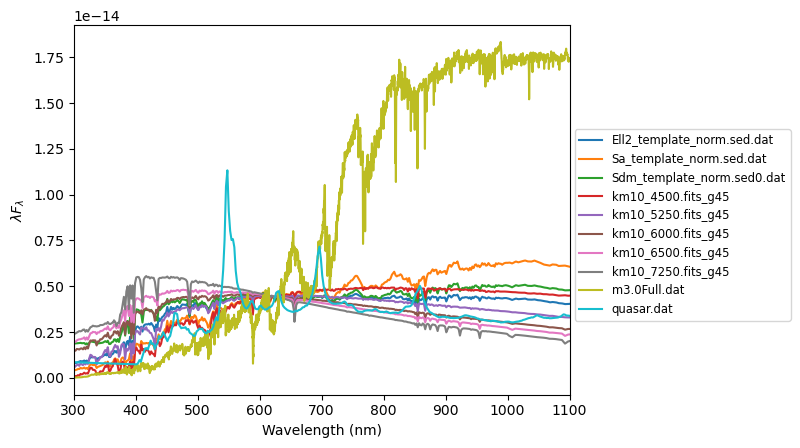

In [8]:
for s in seds:
    plt.plot(seds[s].wavelen, seds[s].flambda*seds[s].wavelen, label='%s' %(s))
plt.xlabel('Wavelength (nm)')
plt.ylabel('$\lambda F_\lambda$')
plt.xlim(300, 1100)
plt.legend(loc=(1.01, 0.2), fontsize='smaller', numpoints=1, fancybox=True)

---
<b>Read in the (non-standard) throughput components</b>

Read in the various components that we will need, in order to generate the non-standard throughput curves at arbitrary airmass. 
First, the system hardware throughput components, as we will need the hardware alone to calculate SNR anyway. (see [note (1)](#hardware_sky) below for more information). 

In [9]:
lsst_system = {}
for f in filterlist:
    lsst_system[f] = Bandpass()
    lsst_system[f].read_throughput_list(['detector.dat', 'lens1.dat', 'lens2.dat', 'lens3.dat', 
                                        'm1.dat', 'm2.dat', 'm3.dat', 'filter_'+f+'.dat'], 
                                        root_dir=throughputsDir)

Then read in the atmosphere, so we can multiply it into the system hardware throughputs. This lets us generate the total throughput curves, using a wider variety of atmosphere curves at varying airmass. (The standard total throughput curves use X=1.2, for now we'll use X=1.0 here).

In [10]:
atmosphere = Bandpass()
X = 1.0
atmosphere.read_throughput(os.path.join(atmosDir, 'atmos_%d.dat' %(X*10)))
atmosphere.resample_bandpass()

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/phot_utils/bandpass.py:67: UserWarning: Wavelength sampling of 100.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Calculate the total (non-standard) throughput curves, including the atmosphere. 

In [11]:
lsst_total = {}
for f in filterlist:
    wavelen, sb = lsst_system[f].multiply_throughputs(atmosphere.wavelen, atmosphere.sb)
    lsst_total[f] = Bandpass(wavelen=wavelen, sb=sb)

Pretty plot #2, plot the throughput curves + atmosphere.  The dotted lines are the hardware-only throughputs, the solid lines are total system throughputs including atmosphere.

Text(0.5, 1.0, 'System throughput')

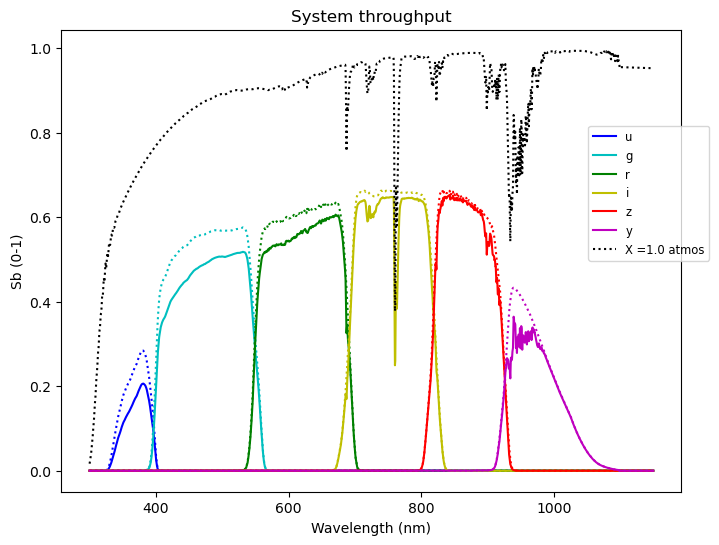

In [12]:
plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(lsst_total[f].wavelen, lsst_total[f].sb,  linestyle='-', color=filtercolors[f], label='%s' %(f))
    plt.plot(lsst_system[f].wavelen, lsst_system[f].sb, linestyle=':', color=filtercolors[f])
plt.plot(atmosphere.wavelen, atmosphere.sb, 'k:', label='X =%.1f atmos' %(X))
plt.legend(loc=(0.85, 0.5), fontsize='smaller', fancybox=True, numpoints=1)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Sb (0-1)')
plt.title('System throughput')

---
<b>Calculate SNR</b>

The SNR of a source depends on the sky background, as well as properties of the telescope and camera. We can use the default values for LSST telescope and camera properties automatically. At the moment, the only sky spectrum we have easily available is the dark sky zenith spectrum, from the [$LSST_THROUGHPUTS_BASELINE/darksky.dat](https://github.com/lsst/throughputs/blob/master/baseline/darksky.dat) file. This spectra is calibrated to have the appropriate magnitudes in the LSST bandpasses under dark sky, zenith conditions.

In [13]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(throughputsDir, 'darksky.dat'))

Calculate the SNR, assuming optimal measurement over the PSF. This means we can choose the PSF as well.<br>
`Sed` method `calcSNR_psf` accepts an instantiation of the `PhotometricParameters` class, which carries values for readnoise, platescale, gain, number of exposures, etc, set to defaults appropriate for general LSST purposes (and assuming 30 second visits, consisting of two 15 second exposures). 

In [14]:
# Set up the photometric parameters for LSST
photParams = PhotometricParameters(gain=1)
# Set up the seeing. "seeing" traditional = FWHMgeom in our terms 
#  (i.e. the physical size of a double-gaussian or von Karman PSF)
# But we use the equivalent FWHM of a single gaussian in the SNR calculation, so convert.
seeing = 0.7
FWHMeff = SignalToNoise.fwhm_geom2_fwhm_eff(seeing) 

In [15]:
# We can investigate the SNR calculation a little closer for a single object, let's use the Mdwarf.
s = 'm3.0Full.dat'
f = 'r'
print("SNR in %s band" % f)
_ = SignalToNoise.calc_snr_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams, FWHMeff, verbose=True)
print('')
f = 'z'
print("SNR in %s band" % f)
_ = SignalToNoise.calc_snr_sed(seds[s], lsst_total[f], darksky, lsst_system[f], photParams, FWHMeff, verbose=True)

SNR in r band
For Nexp 2.0 of time 15.0: 
Counts from source: 1722.24  Counts from sky: 988.63
fwhm_eff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 31.44 Noise from instrument: 12.68
Noise from source: 41.50
 Total Signal: 1722.24   Total Noise: 205.40    SNR: 8.38

SNR in z band
For Nexp 2.0 of time 15.0: 
Counts from source: 5139.41  Counts from sky: 2381.95
fwhm_eff: 0.79('')  Neff pixels: 35.205(pix)
Noise from sky: 48.81 Noise from instrument: 12.68
Noise from source: 71.69
 Total Signal: 5139.41   Total Noise: 307.67    SNR: 16.70


In [19]:
# Calculate SNR for all seds in all filters.
snr = pd.DataFrame(index=seds, columns=filterlist)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calc_snr_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                                   photParams, fwhm_eff=FWHMeff, verbose=False)
snr

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.794088,8.346215,8.397243,6.899299,4.558363,1.9923
Sa_template_norm.sed.dat,0.471893,6.738641,8.395199,7.872359,5.895971,2.8227
Sdm_template_norm.sed0.dat,1.200354,9.083275,8.397506,7.058464,4.945346,2.284127
km10_4500.fits_g45,0.324617,6.142797,8.394161,7.657222,5.081174,2.166771
km10_5250.fits_g45,0.776774,7.996657,8.396799,6.825806,4.215161,1.694111
km10_6000.fits_g45,1.312993,9.505128,8.39863,6.307701,3.703238,1.427442
km10_6500.fits_g45,1.579392,10.432761,8.399743,6.014255,3.427962,1.296485
km10_7250.fits_g45,1.825652,11.746673,8.401373,5.61354,3.063185,1.140498
m3.0Full.dat,0.174254,3.877171,8.384641,17.486051,16.70437,7.896594
quasar.dat,0.405372,6.756314,8.403495,6.390713,3.954403,1.463726


Note that the SNR in the r band is the approximately same for all of these objects. This makes sense, as we normalized them all to have the same r band standard magnitudes, and the X=1.0 atmosphere is not hugely different from the X=1.2 standard throughput curves.  However, their SNR in other bandpasses can be quite different depending on the SED of the source. 

---
And it's a bit of a hack, but we could make the same calculation for different sky background values, by scaling the dark sky SED to have different expected magnitudes (i.e. adjust the darksky SED to create different sky brightness). 

<a name='hardware_sky'>(1)</a> Notice that I use lsst_system throughputs here, not lsst_total. This is because the sky magnitudes must be calculated using the *system* only, not including the atmosphere. The sky brightness is generated at various points throughout the atmosphere, so should not be propagated through the entire atmosphere when calculating the transmission to the focal plane (unlike sources above the atmosphere). Without doing proper radiative transfer to determine the atmosphere and sky brightness to use, the next best thing is to just use the system minus the atmosphere, and atmosphere-corrected/telescope pupil skybrightness measurements (which are what are usually reported). This is also why we needed to pass the system only throughput curves to calc_snr_sed. 

In [20]:
for f in filterlist:
    print(f, darksky.calc_mag(lsst_system[f]))

u 23.05198265032338
g 22.253839010579107
r 21.197578771874923
i 20.462795492645782
z 19.606304927173184
y 18.601511752334773


In [21]:
newSkyMag = 20.5
newSkyFilter = 'r'
fluxNorm = darksky.calc_flux_norm(newSkyMag, lsst_system[newSkyFilter])
darksky.multiply_flux_norm(fluxNorm)
for f in filterlist:
    print(f, darksky.calc_mag(lsst_system[f]))

u 22.35440387844846
g 21.556260238704184
r 20.5
i 19.76521672077086
z 18.90872615529826
y 17.90393298045985


In [23]:
# Calculate SNR with varied sky brightness
photParams = PhotometricParameters()
seeing = 0.7
FWHMeff = SignalToNoise.fwhm_geom2_fwhm_eff(seeing)
snr = pd.DataFrame(index=seds, columns=filterlist)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calc_snr_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                                  photParams, fwhm_eff=FWHMeff, verbose=False)
snr

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.726056,6.532372,6.359723,5.148317,3.368319,1.466541
Sa_template_norm.sed.dat,0.43133,5.263066,6.358161,5.879522,4.361138,2.079044
Sdm_template_norm.sed0.dat,1.097944,7.116085,6.359924,5.267835,3.655346,1.681709
km10_4500.fits_g45,0.296671,4.793933,6.357368,5.71775,3.75613,1.59517
km10_5250.fits_g45,0.710213,6.255923,6.359383,5.093142,3.113905,1.246775
km10_6000.fits_g45,1.201103,7.450663,6.360783,4.704374,2.734664,1.05032
km10_6500.fits_g45,1.445168,8.187639,6.361633,4.484341,2.530856,0.953871
km10_7250.fits_g45,1.670893,9.234446,6.362878,4.184059,2.260915,0.839011
m3.0Full.dat,0.159229,3.01674,6.350094,13.170663,12.456366,5.837345
quasar.dat,0.370504,5.276992,6.3645,4.766639,2.920695,1.077046


In [24]:
# Vary the seeing (with this new sky background)
photParams = PhotometricParameters()
seeing = 1.2
FWHMeff = SignalToNoise.fwhm_geom2_fwhm_eff(seeing)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calc_snr_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, fwhm_eff=FWHMeff, verbose=False)
display(snr)

,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.410917,3.730111,3.618835,2.921253,1.906651,0.828759
Sa_template_norm.sed.dat,0.243852,2.998604,3.617939,3.338625,2.470691,1.175456
Sdm_template_norm.sed0.dat,0.622232,4.067594,3.61895,2.989432,2.069621,0.950514
km10_4500.fits_g45,0.167641,2.729059,3.617484,3.246232,2.126863,0.90154
km10_5250.fits_g45,0.401927,3.570517,3.61864,2.889784,1.762264,0.704445
km10_6000.fits_g45,0.68095,4.261345,3.619443,2.668151,1.547148,0.593353
km10_6500.fits_g45,0.820047,4.688912,3.619931,2.542789,1.431599,0.538826
km10_7250.fits_g45,0.94891,5.298108,3.620645,2.371796,1.278616,0.473901
m3.0Full.dat,0.089931,1.711966,3.613312,7.534031,7.104574,3.310081
quasar.dat,0.209418,3.006612,3.621575,2.703636,1.652653,0.608464


In [25]:
# Or vary the readnoise (for example) -- notice biggest effect in u band
old_readnoise = photParams.readnoise
print(old_readnoise)
photParams = PhotometricParameters(readnoise=old_readnoise*2)
seeing = 1.2
FWHMeff = SignalToNoise.fwhm_geom2_fwhm_eff(seeing)
for i, s in enumerate(seds):
    for f in filterlist:
        snr.iloc[i][f] = SignalToNoise.calc_snr_sed(seds[s], lsst_total[f], darksky, lsst_system[f], 
                                              photParams, fwhm_eff=FWHMeff, verbose=False)
snr

8.8


,u,g,r,i,z,y
Ell2_template_norm.sed.dat,0.242288,3.107466,3.268335,2.729583,1.818897,0.794853
Sa_template_norm.sed.dat,0.143734,2.497241,3.267525,3.119709,2.357059,1.127386
Sdm_template_norm.sed0.dat,0.367038,3.389131,3.268439,2.793309,1.974386,0.911632
km10_4500.fits_g45,0.098798,2.272487,3.267114,3.033345,2.029001,0.864659
km10_5250.fits_g45,0.236983,2.974298,3.268159,2.70017,1.68114,0.67562
km10_6000.fits_g45,0.401721,3.550874,3.268885,2.49302,1.475907,0.569071
km10_6500.fits_g45,0.483912,3.907907,3.269325,2.375854,1.365668,0.516773
km10_7250.fits_g45,0.560097,4.416842,3.269971,2.216046,1.219719,0.454504
m3.0Full.dat,0.052992,1.424898,3.263343,7.043171,6.779778,3.17507
quasar.dat,0.123429,2.503919,3.270812,2.526186,1.576564,0.583564
